<a href="https://colab.research.google.com/github/rhehgus02/ESAA/blob/main/%ED%8C%8C%EC%9D%B4%EC%8D%AC_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D_%EC%99%84%EB%B2%BD_%EA%B0%80%EC%9D%B4%EB%93%9C(8)_%EB%B6%84%EB%A5%98(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

### **2-5. 결정 트리 실습 - 사용자 행동 인식 데이터 세트**

* 데이터: 30명에게 스마트폰 센서를 장착한 뒤 사람의 동작과 관련된 여러 가지 피처(561개)를 수집한 데이터

* 목표: 수집된 피처 세트를 기반으로 결정 트리를 이용해 어떤 동작인지 예측

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 피처의 명칭 간략히 확인하기

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# features.txt 파일에는 피처 이름 index와 피처명이 공백으로 분리되어 있음. 이를 DataFrame으로 로드.
feature_name_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ESAA/data/features.txt',
                              sep='\s+', header=None, names=['column_index','column_name'])

# 피처명 index를 제거하고, 피처명만 리스트 객체로 생성한 뒤 샘플로 10개만 추출
feature_name = feature_name_df.iloc[:, 1].values.tolist()
print('전체 피처명에서 10개만 추출:', feature_name[:10])

전체 피처명에서 10개만 추출: ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X']


>> 인체의 움직임과 관련된 속성의 평균/표준편차가 X, Y, Z축 값으로 돼 있음을 유추할 수 있음

In [3]:
feature_name_df.head()

,column_index,column_name
0,1,tBodyAcc-mean()-X
1,2,tBodyAcc-mean()-Y
2,3,tBodyAcc-mean()-Z
3,4,tBodyAcc-std()-X
4,5,tBodyAcc-std()-Y


In [4]:
# 중복된 피처명이 얼마나 있는지 알아보기
feature_dup_df = feature_name_df.groupby('column_name').count()
print(feature_dup_df[feature_dup_df['column_index']>1].count())
feature_dup_df[feature_dup_df['column_index']>1].head()

column_index    42
dtype: int64


,column_index
column_name,
"fBodyAcc-bandsEnergy()-1,16",3
"fBodyAcc-bandsEnergy()-1,24",3
"fBodyAcc-bandsEnergy()-1,8",3
"fBodyAcc-bandsEnergy()-17,24",3
"fBodyAcc-bandsEnergy()-17,32",3


>> 총 42개의 피처명이 중복되어 있음

>> 중복된 피처명에 대해서는 원본 피처명에 _1 또는 _2를 추가해야 함

In [5]:
# 새로운 피처명을 가지는 DataFrame을 반환하는 함수 생성

def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(), columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name','dup_cnt']].apply(lambda x: x[0]+'_'+str(x[1]) if x[1]>0 else x[0], axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

In [6]:
# 사용자 행동 인식 데이터 세트 DataFrame을 반환하는 함수

def get_human_dataset( ):
    
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당
    feature_name_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ESAA/data/features.txt', 
                                  sep='\s+', header=None, names=['column_index','column_name'])

    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame생성. 
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    # DataFrame에 피처명을 칼럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처 데이터 세트와 테스트 피처 데이터를 DataFrame으로 로딩. 칼럼명은 feature_name 적용
    X_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ESAA/data/X_train.txt', sep='\s+', names=feature_name)
    X_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ESAA/data/X_test.txt', sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터를 DataFrame으로 로딩하고 칼럼명은 action으로 부여
    y_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ESAA/data/y_train.txt', sep='\s+', header=None, names=['action'])
    y_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ESAA/data/y_test.txt', sep='\s+', header=None, names=['action'])
    
    # 로드된 학습/테스트용 DataFrame을 모두 반환 
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_human_dataset()

In [7]:
print('## 학습 피처 데이터 세트 info() ##')
print(X_train.info())

## 학습 피처 데이터 세트 info() ##
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB
None


>> 학습 데이터 세트는 7352개의 행과 561개의 칼럼으로 되어 있음

>> 피처가 전부 float형이기 때문에 별도의 카테고리 인코딩은 안 해도 됨

In [8]:
print(y_train['action'].value_counts())

6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: action, dtype: int64


>> 레이블 값은 1~6까지의 6개 값이고 분포도는 특정 값으로 왜곡되지 않고 비교적 고르게 분포되어 있음

In [9]:
# 하이퍼 파라미터를 디폴트 값으로 DecisionTreeClassifier을 이용해 동작 예측 분류 수행

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# 예제 반복 시마다 동일한 예측 결과 도출을 위해 random_state 설정
dt_clf = DecisionTreeClassifier(random_state=156)
dt_clf.fit(X_train, y_train)
pred = dt_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('결정 트리 예측 정확도: {0:.4f}'.format(accuracy))

# DecisionTreeClassifier의 하이퍼 파라미터 추출
print('DecisionTreeClassifier 기본 하이퍼 파라미터:\n', dt_clf.get_params())

결정 트리 예측 정확도: 0.8548
DecisionTreeClassifier 기본 하이퍼 파라미터:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 156, 'splitter': 'best'}


>> 약 85.48%의 정확도를 나타냄

In [11]:
# max_depth 값을 변화시키면서 예측 성능 측정

from sklearn.model_selection import GridSearchCV

params={
    'max_depth': [6,8,10,12,16,20,24]
}

grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1)
grid_cv.fit(X_train, y_train)
print('GridSearchCV 최고 평균 정확도 수치: {0:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터:', grid_cv.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
GridSearchCV 최고 평균 정확도 수치: 0.8513
GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 16}


>> max_depth가 16일 때 5개의 폴드 세트의 최고 평균 정확도 결과가 약 85.13%로 도출됨

In [12]:
# GridSearchCV의 'cv_results'_ 속성: 하이퍼 파라미터 각각의 성능 수치
# 'cv_results_'의 'mean_test_score': 평가 데이터 세트의 평균 정확도 수치

# GridSearchCV 객체의 cv_results_ 속성을 DataFrame으로 생성.
cv_results_df = pd.DataFrame(grid_cv.cv_results_)

# max_depth 파라미터 값과 그때의 테스트 세트, 학습 데이터 세트의 정확도 수치 추출
cv_results_df[['param_max_depth', 'mean_test_score']]

,param_max_depth,mean_test_score
0,6,0.850791
1,8,0.851069
2,10,0.851209
3,12,0.844135
4,16,0.851344
5,20,0.850800
6,24,0.849440


>> 정확도가 정점을 찍으면 이를 넘어가면서 정확도가 계속 떨어짐

>> 깊은 트리는 검증 데이터 세트에서 과적합으로 인한 성능 저하를 유발함

In [15]:
# 별도의 테스트 데이터 세트에서 정확도 측정하기

max_depths = [6,8,10,12,16,20,24]
# max_depth 값을 변화시키면서 그때마다 학습과 테스트 세트에서의 예측 성능 측정
for depth in max_depths:
    dt_clf = DecisionTreeClassifier(max_depth=depth, random_state=156)
    dt_clf.fit(X_train, y_train)
    pred = dt_clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    print('max_depth = {0} 정확도: {1:.4f}'.format(depth, accuracy))

max_depth = 6 정확도: 0.8558
max_depth = 8 정확도: 0.8707
max_depth = 10 정확도: 0.8673
max_depth = 12 정확도: 0.8646
max_depth = 16 정확도: 0.8575
max_depth = 20 정확도: 0.8548
max_depth = 24 정확도: 0.8548


>> max_depth가 8일 때 가장 높은 정확도를 나타내며, 8을 넘어가면 정확도가 계속 감소함

In [16]:
# max_depth와 min_samples_split을 같이 변경하면서 정확도 성능을 튜닝

params = {
    'max_depth' : [8, 12, 16, 20],
    'min_samples_split' : [16, 24]
}

grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1)
grid_cv.fit(X_train, y_train)
print('GridSearchCV 최고 평균 정확도 수치: {0:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터:', grid_cv.best_params_) 

Fitting 5 folds for each of 8 candidates, totalling 40 fits
GridSearchCV 최고 평균 정확도 수치: 0.8549
GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 8, 'min_samples_split': 16}


>> max_depth가 8, min_samples_split가 16일 때 정확도가 가장 높음

>> 이 하이퍼 파라미터로 학습이 완료된 객체: `grid_cv.best_estimator_`

In [17]:
# 다시 별도 분리된 테스트 데이터 세트에 해당 하이퍼 파라미터 적용
best_dt_clf = grid_cv.best_estimator_
pred1 = best_dt_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred1)
print('결정 트리 예측 정확도: {0:.4f}'.format(accuracy))

결정 트리 예측 정확도: 0.8717


>> 정확도는 약 87.17%

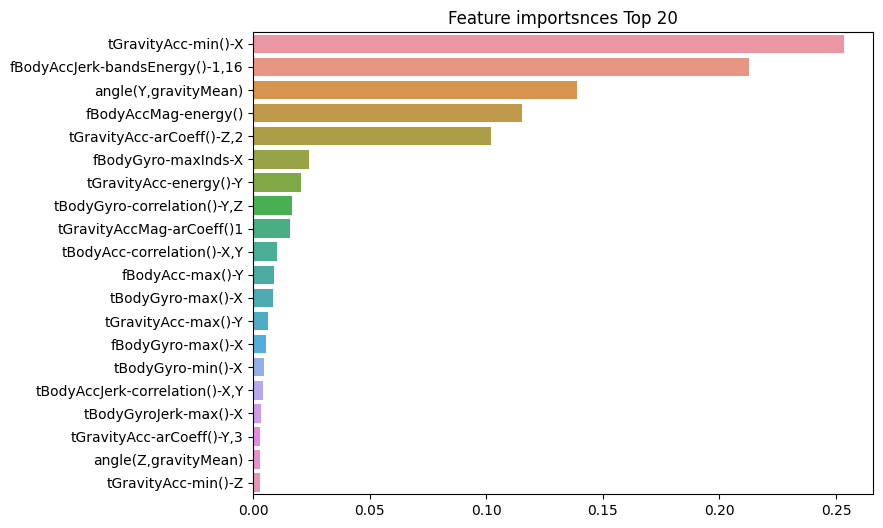

In [18]:
# 결정 트리에서 각 피처의 중요도를 feature_importances_ 속성 이용해 알아보기
import seaborn as sns

ftr_importances_values = best_dt_clf.feature_importances_
# Top 중요도로 정렬을 쉽게 하고, 시본의 막대그래프로 쉽게 표현하기 위해 Series 변환
ftr_importances = pd.Series(ftr_importances_values, index = X_train.columns)
# 중요도 값 순으로 Series를 정렬
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
plt.figure(figsize=(8,6))
plt.title('Feature importsnces Top 20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

>> 가장 높은 중요도를 가진 Top5 피처들이 매우 중요하게 규칙 생성에 영향을 미치고 있는 것을 알 수 있음